In [41]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from config import RAW_DATA_DIR

# Show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Show full width
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 0)

### Shelter System Flow

In [61]:
sys_flow = pd.read_csv(RAW_DATA_DIR / "toronto-shelter-system-flow.csv")
sys_flow.head(15)

,_id,date(mmm-yy),population_group,returned_from_housing,returned_to_shelter,newly_identified,moved_to_housing,became_inactive,actively_homeless,ageunder16,age16-24,age25-34,age35-44,age45-54,age55-64,age65over,gender_male,gender_female,"gender_transgender,non-binary_or_two_spirit",population_group_percentage
0,1,Jan-18,All Population,46,494,1106,508,862,7958,1233,1111,1341,1560,1318,973,422,4963,2912,83,100.0%
1,2,Jan-18,Chronic,11,29,317,111,111,2532,223,346,313,403,505,495,247,1632,870,30,31.8%
2,3,Jan-18,Refugees,4,32,651,328,75,2408,914,241,414,547,204,66,22,1219,1177,12,30.3%
3,4,Jan-18,Families,0,14,561,321,57,2277,1232,187,276,411,130,23,18,968,1308,1,28.6%
4,5,Jan-18,Youth,12,64,116,44,116,924,0,924,0,0,0,0,0,571,312,41,11.6%
5,6,Jan-18,Single Adult,34,416,429,143,689,4757,0,0,1065,1149,1188,950,404,3424,1292,41,59.8%
6,7,Jan-18,Non-refugees,42,462,455,180,787,5550,319,870,927,1013,1114,907,400,3744,1735,71,69.7%
7,8,Feb-18,All Population,78,481,947,489,757,8132,1271,1094,1392,1579,1399,965,432,5093,2959,80,100.0%
8,9,Feb-18,Chronic,11,31,217,152,73,2541,202,362,308,399,521,496,253,1652,862,27,31.2%
9,10,Feb-18,Refugees,8,26,490,345,89,2491,965,253,417,534,237,66,19,1264,1214,13,30.6%


In [43]:
sys_flow.isna().sum()

_id                                            0
date(mmm-yy)                                   0
population_group                               0
returned_from_housing                          0
returned_to_shelter                            0
newly_identified                               0
moved_to_housing                               0
became_inactive                                0
actively_homeless                              0
ageunder16                                     0
age16-24                                       0
age25-34                                       0
age35-44                                       0
age45-54                                       0
age55-64                                       0
age65over                                      0
gender_male                                    0
gender_female                                  0
gender_transgender,non-binary_or_two_spirit    0
population_group_percentage                    0
dtype: int64

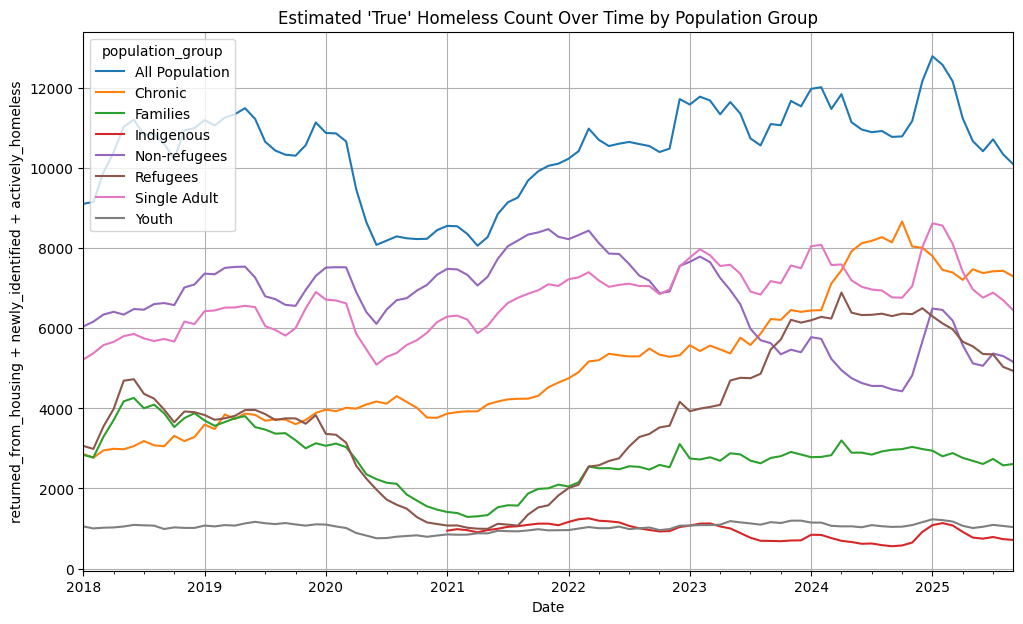

In [62]:
sys_flow["date(mmm-yy)"] = pd.to_datetime(sys_flow["date(mmm-yy)"], format="%b-%y")

cols_to_sum = ["returned_from_housing", "newly_identified", "actively_homeless"]
sys_flow["true_total"] = sys_flow[cols_to_sum].fillna(0).sum(axis=1)

pivot_df = sys_flow.pivot(
    index="date(mmm-yy)",
    columns="population_group",
    values="true_total"
).sort_index()

ax = pivot_df.plot(kind="line", figsize=(12, 7))
ax.set_title("Estimated 'True' Homeless Count Over Time by Population Group")
ax.set_xlabel("Date")
ax.set_ylabel("returned_from_housing + newly_identified + actively_homeless")
ax.grid(True)

### Demand for each month (Net Flow)

In [ ]:
sys_flow_2024 = sys_flow[sys_flow["date(mmm-yy)"].dt.year == 2024]

single_adult_df = sys_flow_2024[sys_flow_2024["population_group"] == "Single Adult"]

single_adult_df = single_adult_df[
    ["date(mmm-yy)", "true_total", "gender_male", "gender_female"]
]

single_adult_df = single_adult_df.sort_values("date(mmm-yy)").reset_index(drop=True)
single_adult_df

,date(mmm-yy),true_total,gender_male,gender_female
0,2024-01-01,8051,4979,2344
1,2024-02-01,8086,5083,2408
2,2024-03-01,7582,4872,2306
3,2024-04-01,7595,4775,2297
4,2024-05-01,7197,4629,2277
5,2024-06-01,7039,4507,2250
6,2024-07-01,6969,4396,2251
7,2024-08-01,6946,4397,2251
8,2024-09-01,6774,4288,2184
9,2024-10-01,6765,4259,2200


### Shelter Locations (City Hostel Serviced)

In [45]:
xls_path = RAW_DATA_DIR / "shelter-locations-readme.xls"

xls = pd.ExcelFile(xls_path, engine="xlrd")
print(xls.sheet_names)  # See which sheets exist

df = pd.read_excel(
    xls_path,
    engine="xlrd",
    header=1,  # Real headers start on the second row
    usecols="A:C",  # Item name, Description, Datatype cols
)

df = df.dropna(how="all").reset_index(drop=True)
df.columns = ["ITEM_NAME", "DESCRIPTION", "DATATYPE"]
df = df.drop(0)
df

['Sheet1', 'Sheet2', 'Sheet3']


,ITEM_NAME,DESCRIPTION,DATATYPE
1,FID,Feature ID,Numeric
2,SHAPE,Feature type e.g. point,NaN
3,ADDRESS_PO,Unique geographical Address Identifier,Numeric
4,ADDRESS_FU,Full municipal address,NaN
5,POSTAL_COD,Postal code,NaN
6,MUNICIPALI,Former city municipality,NaN
7,CITY,Toronto,NaN
8,CENTRELINE,The unique geographic identifier of the street segment the address is on,Numeric
9,OBJECTID,Object identifier,Numeric
10,WARD,Toronto Electoral Ward name and number,NaN


In [46]:
import geopandas as gpd

shelter_locations_df = gpd.read_file(RAW_DATA_DIR / "shelters_wgs84.shp")
shelter_locations_df.to_csv(RAW_DATA_DIR / "shelter_wgs8.csv")

shelter_locations_df.head(5)

,ADDRESS_PO,ADDRESS_FU,POSTAL_COD,MUNICIPALI,CITY,CENTRELINE,OBJECTID,WARD,NEIGHBOURH,NEIGHBOU_1,COMMUNITY_,CONFIDENTI,MOTEL,CAPACITY,NAME,TYPE,TYPE2,CITY_OP,geometry
0,808260,70 Gerrard St E,M5B1G6,former TORONTO,Toronto,1143800,44,Toronto Centre-Rosedale (27),75,Church-Yonge Corridor,TORONTO AND EAST YORK COMMUNITY COUNCIL,N,None,38,St. Vincent De Paul - Mary's Home,Single,Single Women,None,POINT (-79.37841 43.66015)
1,9531684,3410 Bayview Ave,M2M3S3,NORTH YORK,Toronto,9531674,45,Willowdale (24),50,Newtonbrook East,NORTH YORK COMMUNITY COUNCIL,N,None,30,St. Vincent De Paul - St. Clare's Residence,Single,Single Women,None,POINT (-79.39544 43.79811)
2,2591634,87 Pembroke St,M5A2N9,former TORONTO,Toronto,14020526,46,Toronto Centre-Rosedale (27),73,Moss Park,TORONTO AND EAST YORK COMMUNITY COUNCIL,N,None,33,Street Haven at the Crossroads,Single,Single Women,None,POINT (-79.37243 43.65924)
3,8067796,129 Peter St,M5V2H3,former TORONTO,Toronto,20139637,47,Trinity-Spadina (20),77,Waterfront Communities-The Islands,TORONTO AND EAST YORK COMMUNITY COUNCIL,N,None,VARIES,Streets to Homes Assessment & Referral Centre,Single,Mixed Adult,Y,POINT (-79.39324 43.64875)
4,6362877,191 Spadina Rd,M5R2T9,former TORONTO,Toronto,6362837,48,Trinity-Spadina (20),95,Annex,TORONTO AND EAST YORK COMMUNITY COUNCIL,N,None,24,Toronto Community Hostel,Family,Family,None,POINT (-79.40628 43.67362)


In [47]:
shelter_locations_df.isna().sum()

ADDRESS_PO     0
ADDRESS_FU     0
POSTAL_COD     1
MUNICIPALI     0
CITY           0
CENTRELINE     0
OBJECTID       0
WARD           0
NEIGHBOURH     0
NEIGHBOU_1     0
COMMUNITY_     0
CONFIDENTI     0
MOTEL         55
CAPACITY       0
NAME           0
TYPE           0
TYPE2          0
CITY_OP       45
geometry       0
dtype: int64

['Single Women' 'Mixed Adult' 'Family' 'Youth' 'Single Men']


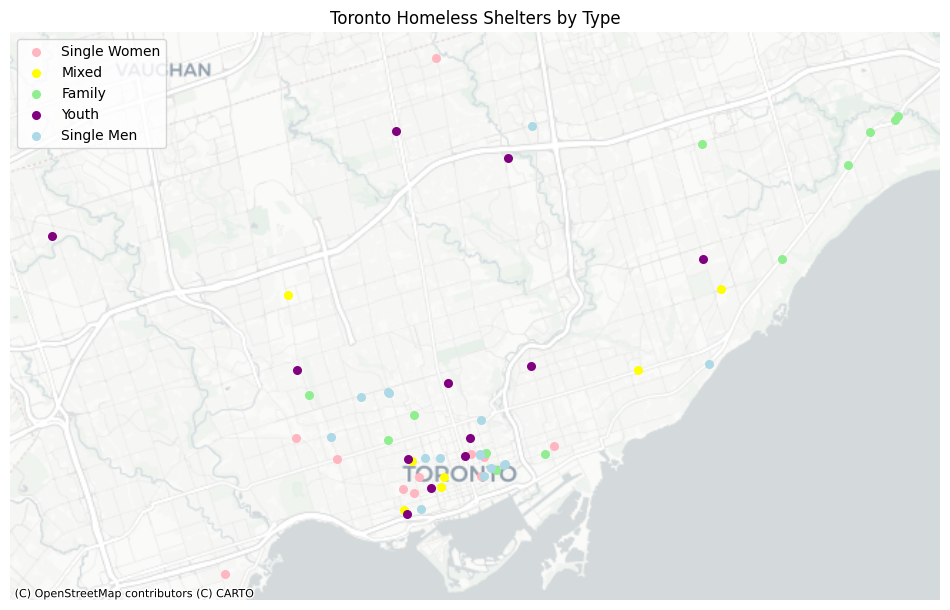

In [48]:
import contextily as cx

shelters_webmer = shelter_locations_df.to_crs(epsg=3857)

print(shelter_locations_df["TYPE2"].unique())

shelter_locations_single_wom = shelters_webmer[
    shelter_locations_df["TYPE2"] == "Single Women"
]
shelter_locations_mixed = shelters_webmer[
    shelter_locations_df["TYPE2"] == "Mixed Adult"
]
shelter_locations_family = shelters_webmer[shelter_locations_df["TYPE2"] == "Family"]
shelter_locations_youth = shelters_webmer[shelter_locations_df["TYPE2"] == "Youth"]
shelter_locations_single_men = shelters_webmer[
    shelter_locations_df["TYPE2"] == "Single Men"
]

fig, ax = plt.subplots(figsize=(12, 10))

shelter_locations_single_wom.plot(
    ax=ax, color="lightpink", markersize=30, label="Single Women"
)
shelter_locations_mixed.plot(ax=ax, color="yellow", markersize=30, label="Mixed")
shelter_locations_family.plot(ax=ax, color="lightgreen", markersize=30, label="Family")
shelter_locations_youth.plot(ax=ax, color="purple", markersize=30, label="Youth")
shelter_locations_single_men.plot(
    ax=ax, color="lightblue", markersize=30, label="Single Men"
)

cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron)

plt.title("Toronto Homeless Shelters by Type")
plt.axis("off")
plt.legend()
plt.show()

### Daily Shelter & Overnight Service Occupancy & Capacity

In [49]:
daily_occ_cap_df = pd.read_csv(
    RAW_DATA_DIR / "daily-shelter-overnight-service-occupancy-capacity-2024.csv"
)

daily_occ_cap_df.head(10)

,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,LOCATION_PROVINCE,PROGRAM_ID,PROGRAM_NAME,SECTOR,PROGRAM_MODEL,OVERNIGHT_SERVICE_TYPE,PROGRAM_AREA,SERVICE_USER_COUNT,CAPACITY_TYPE,CAPACITY_ACTUAL_BED,CAPACITY_FUNDING_BED,OCCUPIED_BEDS,UNOCCUPIED_BEDS,UNAVAILABLE_BEDS,CAPACITY_ACTUAL_ROOM,CAPACITY_FUNDING_ROOM,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS
0,1,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,Toronto,ON,16892,COSTI - Hotel Program - Dixon (Refugee Families),Families,Emergency,Motel/Hotel Shelter,Temporary Refugee Response,650,Room Based Capacity,NaN,NaN,NaN,NaN,NaN,149.0,150.0,149.0,0.0,1.0,NaN,100.0
1,2,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,Toronto,ON,16891,COSTI - Hotel Program - Dixon (Refugee Singles),Mixed Adult,Emergency,Motel/Hotel Shelter,Temporary Refugee Response,113,Room Based Capacity,NaN,NaN,NaN,NaN,NaN,57.0,57.0,57.0,0.0,0.0,NaN,100.0
2,3,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1051.0,COSTI Reception Centre,100 Lippincott St,M5S 2P1,Toronto,ON,12251,COSTI Reception Centre CITY Program,Mixed Adult,Emergency,Shelter,Base Program - Refugee,8,Bed Based Capacity,8.0,8.0,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
3,4,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,North York,ON,15372,COSTI Uptown Hotel COVID-19 - Family Program,Families,Emergency,Motel/Hotel Shelter,Temporary Programs,203,Room Based Capacity,NaN,NaN,NaN,NaN,NaN,67.0,83.0,67.0,0.0,16.0,NaN,100.0
4,5,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,North York,ON,13751,COSTI Uptown Hotel Family Program,Families,Emergency,Motel/Hotel Shelter,Temporary Refugee Response,508,Room Based Capacity,NaN,NaN,NaN,NaN,NaN,161.0,148.0,161.0,0.0,0.0,NaN,100.0
5,6,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1160.0,CONC Etobicoke Hotel Program,445 Rexdale Blvd,M9W 6P8,Etobicoke,ON,16111,CONC Etobicoke Hotel Program - Mixed Adult,Mixed Adult,Emergency,Motel/Hotel Shelter,Temporary Programs,152,Room Based Capacity,NaN,NaN,NaN,NaN,NaN,142.0,152.0,142.0,0.0,10.0,NaN,100.0
6,7,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1172.0,CONC West End Hotel Program,14 Roncesvalles Ave,M6R 2K3,Toronto,ON,15711,CONC Men's Hotel Program,Men,Emergency,Motel/Hotel Shelter,Temporary Programs,39,Room Based Capacity,NaN,NaN,NaN,NaN,NaN,39.0,41.0,39.0,0.0,2.0,NaN,100.0
7,8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,Toronto,ON,12011,Christie Ossington Men's Hostel,Men,Emergency,Shelter,Base Shelter and Overnight Services System,42,Bed Based Capacity,42.0,42.0,42.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
8,9,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1102.0,CONC Men's Shelter Bloor St W,850 Bloor St W,M6G 1M2,Toronto,ON,13611,Christie Ossington Men's Hostel South,Men,Emergency,Shelter,Base Shelter and Overnight Services System,30,Bed Based Capacity,30.0,30.0,30.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
9,10,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1541.0,Christie Ossington - Spadina Rd,136 Spadina Rd,M5R 2T8,Toronto,ON,17891,Christie Ossington Warming Centre - Spadina Rd,Mixed Adult,Emergency,Warming Centre,Winter Programs,19,Bed Based Capacity,23.0,23.0,19.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,82.61,NaN


In [50]:
# Keeping shelters that work with beds instead of rooms
daily_occ_cap_df = daily_occ_cap_df[daily_occ_cap_df['CAPACITY_TYPE'] == 'Bed Based Capacity']
daily_occ_cap_df.head()

,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,LOCATION_PROVINCE,PROGRAM_ID,PROGRAM_NAME,SECTOR,PROGRAM_MODEL,OVERNIGHT_SERVICE_TYPE,PROGRAM_AREA,SERVICE_USER_COUNT,CAPACITY_TYPE,CAPACITY_ACTUAL_BED,CAPACITY_FUNDING_BED,OCCUPIED_BEDS,UNOCCUPIED_BEDS,UNAVAILABLE_BEDS,CAPACITY_ACTUAL_ROOM,CAPACITY_FUNDING_ROOM,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS
2,3,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1051.0,COSTI Reception Centre,100 Lippincott St,M5S 2P1,Toronto,ON,12251,COSTI Reception Centre CITY Program,Mixed Adult,Emergency,Shelter,Base Program - Refugee,8,Bed Based Capacity,8.0,8.0,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
7,8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,Toronto,ON,12011,Christie Ossington Men's Hostel,Men,Emergency,Shelter,Base Shelter and Overnight Services System,42,Bed Based Capacity,42.0,42.0,42.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
8,9,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1102.0,CONC Men's Shelter Bloor St W,850 Bloor St W,M6G 1M2,Toronto,ON,13611,Christie Ossington Men's Hostel South,Men,Emergency,Shelter,Base Shelter and Overnight Services System,30,Bed Based Capacity,30.0,30.0,30.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
9,10,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1541.0,Christie Ossington - Spadina Rd,136 Spadina Rd,M5R 2T8,Toronto,ON,17891,Christie Ossington Warming Centre - Spadina Rd,Mixed Adult,Emergency,Warming Centre,Winter Programs,19,Bed Based Capacity,23.0,23.0,19.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,82.61,NaN
12,13,2024-01-01,1,City of Toronto,53,Birkdale Residence,1561.0,885 Scarborough Golf Club Road,885 Scarborough Golf Club Road,M1G 1J6,Toronto,ON,17931,TSSS - Warming Centre - Scarborough Golf Club Road,Mixed Adult,Emergency,Warming Centre,Winter Programs,21,Bed Based Capacity,48.0,48.0,21.0,27.0,0.0,NaN,NaN,NaN,NaN,NaN,43.75,NaN


In [51]:
print(daily_occ_cap_df.shape)
daily_occ_cap_df[
    [
        "SERVICE_USER_COUNT",
        "CAPACITY_ACTUAL_BED",
        "CAPACITY_FUNDING_BED",
        "OCCUPIED_BEDS",
        "UNOCCUPIED_BEDS",
        "UNAVAILABLE_BEDS",
        "OCCUPANCY_RATE_BEDS",
    ]
].describe().drop(index='count')

(34766, 32)


,SERVICE_USER_COUNT,CAPACITY_ACTUAL_BED,CAPACITY_FUNDING_BED,OCCUPIED_BEDS,UNOCCUPIED_BEDS,UNAVAILABLE_BEDS,OCCUPANCY_RATE_BEDS
mean,47.600098,48.04444,49.004746,47.600098,0.444342,0.960306,98.004505
std,43.843958,43.74754,44.112112,43.843958,1.718151,5.697982,6.948390
min,1.000000,1.00000,2.000000,1.000000,-1.000000,-1.000000,2.040000
25%,23.000000,23.00000,24.000000,23.000000,0.000000,0.000000,100.000000
50%,36.000000,36.00000,37.000000,36.000000,0.000000,0.000000,100.000000
75%,62.000000,62.00000,66.000000,62.000000,0.000000,0.000000,100.000000
max,278.000000,278.00000,278.000000,278.000000,80.000000,139.000000,101.470000


In [52]:
daily_occ_cap_df.isna().sum()

_id                           0
OCCUPANCY_DATE                0
ORGANIZATION_ID               0
ORGANIZATION_NAME             0
SHELTER_ID                    0
SHELTER_GROUP                 0
LOCATION_ID                   5
LOCATION_NAME               371
LOCATION_ADDRESS           1495
LOCATION_POSTAL_CODE       1469
LOCATION_CITY              1484
LOCATION_PROVINCE          1484
PROGRAM_ID                    0
PROGRAM_NAME                  0
SECTOR                        0
PROGRAM_MODEL                 0
OVERNIGHT_SERVICE_TYPE        0
PROGRAM_AREA                  0
SERVICE_USER_COUNT            0
CAPACITY_TYPE                 0
CAPACITY_ACTUAL_BED           0
CAPACITY_FUNDING_BED          0
OCCUPIED_BEDS                 0
UNOCCUPIED_BEDS               0
UNAVAILABLE_BEDS              0
CAPACITY_ACTUAL_ROOM      34766
CAPACITY_FUNDING_ROOM     34766
OCCUPIED_ROOMS            34766
UNOCCUPIED_ROOMS          34766
UNAVAILABLE_ROOMS         34766
OCCUPANCY_RATE_BEDS           0
OCCUPANC

In [53]:
num_shelter_daily_occ_cap = daily_occ_cap_df["LOCATION_ADDRESS"].nunique()
num_shelter_locations = shelter_locations_df["NAME"].nunique()

print(f"There are a total of {num_shelter_daily_occ_cap} shelters in the daily occ + cap dataset")
print(f"There are a total of {num_shelter_locations} shelters in the shelter location dataset")

num_programs = daily_occ_cap_df["PROGRAM_NAME"].nunique()
actual_programs = daily_occ_cap_df["PROGRAM_NAME"].unique()
print(f"There are a total of {num_programs} programs")

num_sectors = daily_occ_cap_df["SECTOR"].nunique()
actual_sectors = daily_occ_cap_df["SECTOR"].unique()
print(f"There are a total of {num_sectors}: {actual_sectors}")

There are a total of 77 shelters in the daily occ + cap dataset
There are a total of 59 shelters in the shelter location dataset
There are a total of 114 programs
There are a total of 4: ['Mixed Adult' 'Men' 'Women' 'Youth']


In [54]:
for sector in actual_sectors:
    num_locations = daily_occ_cap_df[daily_occ_cap_df['SECTOR'] == sector]['LOCATION_ADDRESS'].nunique()
    print(f"There are {num_locations} shelters for the {sector} sector")

print("\nOverlap possible since a shelter can accodomate multiple different sectors")

There are 28 shelters for the Mixed Adult sector
There are 22 shelters for the Men sector
There are 18 shelters for the Women sector
There are 16 shelters for the Youth sector

Overlap possible since a shelter can accodomate multiple different sectors


In [ ]:
import matplotlib.pyplot as plt

grouped = daily_occ_cap_df.groupby("PROGRAM_ID")
program_groups = list(grouped)

plots_per_page = 10
for i in range(0, len(program_groups), plots_per_page):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 18)) 
    axes = axes.flatten()

    page_groups = program_groups[i : i + plots_per_page]

    for ax, (program_id, df) in zip(axes, page_groups):
        df = df.set_index("OCCUPANCY_DATE")[["OCCUPIED_BEDS", "CAPACITY_ACTUAL_BED"]].sort_index()
        df.plot(ax=ax, title=f"Program {program_id}")
        
        ax.tick_params(axis='x', labelrotation=90)

    for j in range(len(page_groups), plots_per_page):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [59]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

from geopandas.tools import geocode

daily_occ_cap_df["FULL_ADDRESS"] = (
    daily_occ_cap_df["LOCATION_ADDRESS"].fillna("").str.strip()
    + ", "
    + daily_occ_cap_df["LOCATION_CITY"].fillna("").str.strip()
    + ", "
    + daily_occ_cap_df["LOCATION_PROVINCE"].fillna("").str.strip()
    + ", Canada"
)

daily_occ_cap_filtered_df = daily_occ_cap_df[["FULL_ADDRESS", "PROGRAM_AREA", "SECTOR"]]

unique_addrs = (
    daily_occ_cap_filtered_df.dropna(subset=["FULL_ADDRESS"])
    .drop_duplicates(subset=["FULL_ADDRESS"])
    .reset_index(drop=True)
)

unique_addrs = unique_addrs.drop([34, 74, 77])
unique_addrs = unique_addrs[
    (unique_addrs["SECTOR"] != "Mixed Adult")
    & (unique_addrs["SECTOR"] != "Youth")
]

unique_addrs = unique_addrs[
    unique_addrs['FULL_ADDRESS'] != 
              
]

# gdf_geo = geocode(
#     unique_addrs["FULL_ADDRESS"],
#     provider="nominatim",
#     user_agent="geo_example",
#     timeout=10,
# )

# gdf = gpd.GeoDataFrame(
#     pd.concat([unique_addrs.reset_index(drop=True), gdf_geo[["geometry"]]], axis=1),
#     geometry="geometry",
#     crs="EPSG:4326",
# )

# gdf_3857 = gdf.to_crs(epsg=3857)

# ax = gdf_3857.plot(figsize=(8, 8), markersize=10, column="SECTOR", legend=True)
# cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
# ax.set_axis_off()
# plt.title("Shelter Locations")
# plt.show()

,FULL_ADDRESS,PROGRAM_AREA,SECTOR
1,"973 Lansdowne Ave, Toronto, ON, Canada",Base Shelter and Overnight Services System,Men
2,"850 Bloor St W, Toronto, ON, Canada",Base Shelter and Overnight Services System,Men
5,"1651 Sheppard Ave W, Toronto, ON, Canada",Base Shelter and Overnight Services System,Men
6,"38 Bathurst St, Toronto, ON, Canada",Base Shelter and Overnight Services System,Men
7,"705 Progress Ave, Toronto, ON, Canada",Base Shelter and Overnight Services System,Men
9,"731 Runnymede Rd, Toronto, ON, Canada",Base Shelter and Overnight Services System,Men
10,"339 George St, Toronto, ON, Canada",Base Shelter and Overnight Services System,Men
11,"76 Church St, Toronto, ON, Canada",Base Shelter and Overnight Services System,Men
13,"674 Dundas St W, Toronto, ON, Canada",Base Shelter and Overnight Services System,Women
14,"616 Vaughan Rd, Toronto, ON, Canada",Base Shelter and Overnight Services System,Men


### Scope: Toronto, Men and Women, Bed Based